## 数据集 Dataset
数据是深度学习的基础，高质量的数据输入将在整个深度神经网络中起到积极作用。MindSpore提供基于Pipeline的数据引擎，通过数据集（Dataset）和数据变换（Transforms）实现高效的数据预处理。其中Dataset是Pipeline的起始，用于加载原始数据。mindspore.dataset提供了内置的文本、图像、音频等数据集加载接口，并提供了自定义数据集加载接口。

此外MindSpore的领域开发库也提供了大量的预加载数据集，可以使用API一键下载使用。

### 名词介绍
- 数据引擎：用于将数据集高效、灵活的转换至Tensor，并将该Tensor提供给训练网络用于训练，mindspore数据引擎是将在深度学习过程中数据输入到网络这一中间环境给抽取出来的一个中间件，支持python或c++插件，支持多端数据处理。
- Transforms数据变换：通常情况下，直接加载的原始数据并不能直接送入神经网络进行训练，我们需要对其进行数据预处理。MindSpore提供一个用于不同种类的数据进行变换的通用层mindspore.dataset.transforms，配合数据处理Pipeline来实现数据预处理。所有的Transforms均可通过map方法传入，实现对指定数据列的处理。

In [1]:
import numpy as np
import mindspore.dataset as ds
from mindspore.dataset import vision
from mindspore.dataset import MnistDataset, GeneratorDataset
import matplotlib.pyplot as plt
print('base moudle import')

base moudle import


### 数据集加载

使用**Mnist**数据集作为样例，介绍使用`mindspore.dataset`进行加载的方法。

**注意** `mindspore.dataset`提供的接口**仅支持解压后的数据文件**，这里我们使用`download`库下载数据集并解压。

In [2]:
# mnist数据集下载
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
      "notebook/datasets/MNIST_Data.zip"
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|███████████████████████████| 10.8M/10.8M [00:00<00:00, 154MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


In [3]:
# 直接通过mindspore.dataset内置的MnistDataset类进行mnist数据加载
train_dataset = MnistDataset("MNIST_Data/train", shuffle=False)
print(type(train_dataset))

<class 'mindspore.dataset.engine.datasets_vision.MnistDataset'>


### 数据集迭代

数据集加载后，一般以迭代方式获取数据，然后送入神经网络中进行训练。mindspore.dataset提供create_tuple_iterator和create_dict_iterator接口用于创建数据迭代器，迭代访问数据。

访问的数据类型默认为`Tensor`；若设置`output_numpy=True`，访问的数据类型为`Numpy`。


In [4]:
for idx, item in enumerate(train_dataset.create_tuple_iterator()):
    if idx == 1: break
    print(
        'the create_tuple_iterator generate`s iter length is :', len(item), 
        '\nthe iter item type is :', type(item),
        '\nelement in iter item type is :', [type(i) for i in item]
    )

the create_tuple_iterator generate`s iter length is : 2 
the iter item type is : <class 'list'> 
element in iter item type is : [<class 'mindspore.common.tensor.Tensor'>, <class 'mindspore.common.tensor.Tensor'>]


编写可视化函数查看mnist手写数字识别数据集中图像数据

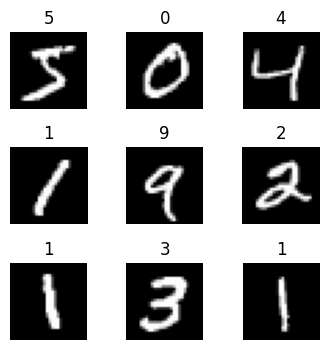

In [5]:
def visualize(dataset):
    figure = plt.figure(figsize=(4, 4))
    cols, rows = 3, 3
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    for idx, (image, label) in enumerate(dataset.create_tuple_iterator()):
        figure.add_subplot(rows, cols, idx + 1)
        plt.title(int(label))
        plt.axis("off")
        plt.imshow(image.asnumpy().squeeze(), cmap="gray")
        if idx == cols * rows - 1:
            break
    plt.show()
visualize(train_dataset)

### 数据集常用操作
Pipeline的设计理念使得数据集的常用操作采用`dataset = dataset.operation()`的异步执行方式，执行操作返回新的Dataset，此时不执行具体操作，而是在Pipeline中加入节点，最终进行迭代时，并行执行整个Pipeline。



#### shuffle

数据集随机`shuffle`可以消除数据排列造成的分布不均问题。

`mindspore.dataset`提供的数据集在加载时可配置`shuffle=True`，或直接对数据集使用`shuffle`方法获取新随机数据集

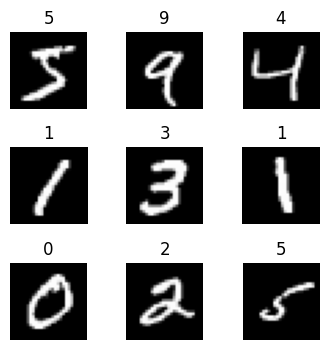

In [6]:
# 参数buffer_size必须，为进行数据重排时每行大小
train_dataset = train_dataset.shuffle(buffer_size=4)
visualize(train_dataset)
# 从下图中可以看到数据顺序发生变化

#### map
`map`操作是数据预处理的关键操作，可以针对数据集指定列（column）添加数据变换（Transforms），将数据变换应用于该列数据的每个元素，并返回包含变换后元素的新数据集。


In [8]:
# 如何查看数据集列名，可以通过create_dict_iterator的dict.keys集合获取
print('train_dataset columns name is:', next(train_dataset.create_dict_iterator()).keys())
image, label = next(train_dataset.create_tuple_iterator())
print('img data shape and type is:', image.shape, image.dtype)
print('label data shape and type is:', label.shape, label.dtype)

train_dataset columns name is: dict_keys(['image', 'label'])
img data shape and type is: (28, 28, 1) UInt8
label data shape and type is: () UInt32


In [18]:
from itertools import product
train_dataset = MnistDataset("MNIST_Data/train", shuffle=False)  # 重新加载数据集
image, label = next(train_dataset.create_tuple_iterator())
print('a image shape is:', image.shape)
# 查看第一张图片所有非零值
the_first_no_zeros_sign = False
the_first_no_zeros_index = None
for i in product(*[range(s) for s in image.shape]):
    if image.item(i):
        if not the_first_no_zeros_sign: 
            print('the first no zeros index is:', i)
            the_first_no_zeros_index, the_first_no_zeros_sign = i, True
            print('first image all no zeros', end=':')
        print(image.item(i), end='-')

a image shape is: (28, 28, 1)
the first no zeros index is: (5, 12, 0)
first image all no zeros:3-18-18-18-126-136-175-26-166-255-247-127-30-36-94-154-170-253-253-253-253-253-225-172-253-242-195-64-49-238-253-253-253-253-253-253-253-253-251-93-82-82-56-39-18-219-253-253-253-253-253-198-182-247-241-80-156-107-253-253-205-11-43-154-14-1-154-253-90-139-253-190-2-11-190-253-70-35-241-225-160-108-1-81-240-253-253-119-25-45-186-253-253-150-27-16-93-252-253-187-249-253-249-64-46-130-183-253-253-207-2-39-148-229-253-253-253-250-182-24-114-221-253-253-253-253-201-78-23-66-213-253-253-253-253-198-81-2-18-171-219-253-253-253-253-195-80-9-55-172-226-253-253-253-253-244-133-11-136-253-253-253-212-135-132-16-

In [19]:
# 通过vision的视觉操作进行image列处理
train_dataset = MnistDataset("MNIST_Data/train", shuffle=False)  # 重新加载数据集
train_dataset = train_dataset.map(vision.Rescale(1.0 / 255.0, 0), input_columns='image')
image, label = next(train_dataset.create_tuple_iterator())
print('map op then first image shape and type is:', image.shape, image.dtype)
print('the first no zeros index is:', the_first_no_zeros_index)
print('the uint8 to float32 value is:', image.item(the_first_no_zeros_index))

map op then first image shape and type is: (28, 28, 1) Float32
the first no zeros index is: (5, 12, 0)
the uint8 to float32 value is: 0.011764707


#### batch

将数据集打包为固定大小的`batch`是在有限硬件资源下使用梯度下降进行模型优化的折中方法，可以保证梯度下降的随机性和优化计算量。

一般我们会设置一个固定的batch size，将连续的数据分为若干批（batch）。

**注意** `batch`操作后的数据增加一维，大小为`batch_size`。

In [10]:
train_dataset = train_dataset.batch(batch_size=4)
image, label = next(train_dataset.create_tuple_iterator())
print(image.shape, image.dtype)

(4, 28, 28, 1) Float32


### 自定义数据集
`mindspore.dataset`模块提供了一些常用的公开数据集和标准格式数据集的加载API。

对于MindSpore暂不支持直接加载的数据集，可以构造自定义数据加载类或自定义数据集生成函数的方式来生成数据集，然后通过`GeneratorDataset`接口实现自定义方式的数据集加载。

`GeneratorDataset`支持通过可随机访问数据集对象、可迭代数据集对象和生成器(generator)构造自定义数据集

1. 可随机访问数据集

可随机访问数据集是实现了`__getitem__`和`__len__`方法的数据集，表示可以通过索引/键直接访问对应位置的数据样本。

例如，当使用`dataset[idx]`访问这样的数据集时，可以读取dataset内容中第idx个样本或标签，该条数据可以通过GeneratorDataset接口转换为Tensor类型。

**注意** 可随机访问数据集在生成迭代Tensor组时，是随机获取的

In [11]:
# 可随机访问数据集，包含5组数据
class RandomAccessDataset:
    def __init__(self):
        self._data = np.eye(5, k=1)
        self._label = np.zeros((5, 1))

    def __getitem__(self, index):
        return self._data[index], self._label[index]

    def __len__(self):
        return len(self._data)
# 自定义数据集转换为mindspore可操作的dataset
loader = RandomAccessDataset()
dataset = GeneratorDataset(source=loader, column_names=["data", "label"])
# 数据随机
for data, label in dataset.create_tuple_iterator():
    print(data, ';', label)

[0. 0. 0. 0. 0.] ; [0.]
[0. 0. 1. 0. 0.] ; [0.]
[0. 0. 0. 0. 1.] ; [0.]
[0. 1. 0. 0. 0.] ; [0.]
[0. 0. 0. 1. 0.] ; [0.]


2. 可迭代数据集

可迭代的数据集是实现了`__iter__`和`__next__`方法的数据集，表示可以通过迭代的方式逐步获取数据样本。这种类型的数据集特别适用于随机访问成本太高或者不可行的情况。

例如，当使用`iter(dataset)`的形式访问数据集时，可以读取从数据库、远程服务器返回的数据流。

下面构造一个简单迭代器，并将其加载至`GeneratorDataset`。

In [12]:
# 可迭代数据集
class IterableDataset():
    def __init__(self, start, end):
        '''初始化迭代器参数'''
        self.start = start
        self.end = end
    def __next__(self):
        '''获取下一迭代数据'''
        return next(self.data)
    def __iter__(self):
        '''创建迭代'''
        self.data = iter(range(self.start, self.end))
        return self
loader = IterableDataset(1, 5)
dataset = GeneratorDataset(source=loader, column_names=["data"])
# in dataset 默认调用create_tuple_iterator()，会将Tensor数据封装进tuple
for d in dataset:
    print(d)

[Tensor(shape=[], dtype=Int64, value= 1)]
[Tensor(shape=[], dtype=Int64, value= 2)]
[Tensor(shape=[], dtype=Int64, value= 3)]
[Tensor(shape=[], dtype=Int64, value= 4)]


3. 生成器

生成器也属于可迭代的数据集类型，其直接依赖Python的生成器类型`generator`返回数据，直至生成器抛出`StopIteration`异常。

下面构造一个生成器，并将其加载至`GeneratorDataset`。

In [13]:
# 生成器构造dataset
dataset = GeneratorDataset(source=iter(range(1,5)), column_names=["data"])
for i in dataset:
    print(i)

[Tensor(shape=[], dtype=Int64, value= 1)]
[Tensor(shape=[], dtype=Int64, value= 2)]
[Tensor(shape=[], dtype=Int64, value= 3)]
[Tensor(shape=[], dtype=Int64, value= 4)]


In [14]:
from datetime import datetime
import pytz
print(datetime.now(pytz.timezone('Asia/Shanghai')), '\nuser:YZSH-HSZY')

2024-07-04 23:39:18.933937+08:00 
user:YZSH-HSZY
